In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import os
import re
import wfdb

In [4]:
diagnostics={"NORM":['NORM','CSD'],
             "STTC":['NDT', 'NST_', 'DIG', 'LNGQT', 'ISC_', 'ISCAL', 'ISCIN', 'ISCIL', 'ISCAS', 'ISCLA', 'ANEUR', 'EL', 'ISCAN' ],
             "MI":['IMI', 'ASMI', 'ILMI', 'AMI', 'ALMI', 'INJAS', 'LMI', 'INJAL', 'IPLMI', 'IPMI', 'INJIN', 'INJLA', 'PMI', 'INJIL'],
             "HYP":['LVH', 'LAO/LAE', 'RVH', 'RAO/RAE', 'SEHYP'],
             "CD":['LAFB', 'IRBBB', '1AVB', 'IVCD', 'CRBBB', 'CLBBB', 'LPFB', 'WPW', 'ILBBB', '3AVB', '2AVB'],
             "OTHER":['AFLT', 'AFIB', 'PSVT', 'STACH', 'PVC', 'PACE', 'PAC']
            }

In [5]:
diagnostics['NORM']

['NORM', 'CSD']

In [7]:

ecg_data=pd.read_csv('C:\\Users\\ppjotrek\\Uni\\mgr\\1Sem\\KBCIDM\\Projekt\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1\\ptbxl_database.csv')
ecg_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr


In [8]:
ecg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21837 entries, 0 to 21836
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ecg_id                        21837 non-null  int64  
 1   patient_id                    21837 non-null  float64
 2   age                           21748 non-null  float64
 3   sex                           21837 non-null  int64  
 4   height                        6983 non-null   float64
 5   weight                        9429 non-null   float64
 6   nurse                         20328 non-null  float64
 7   site                          21819 non-null  float64
 8   device                        21837 non-null  object 
 9   recording_date                21837 non-null  object 
 10  report                        21837 non-null  object 
 11  scp_codes                     21837 non-null  object 
 12  heart_axis                    13332 non-null  object 
 13  i

In [9]:
#Merging the diagnosis into a superclass:
labels=[]
discard=[]
for index in range(ecg_data.shape[0]):
    counter=0
    temp_diag=ecg_data['scp_codes'][index]
    temp_diag=re.sub('{',"",str(temp_diag))
    temp_diag=re.sub('}',"",temp_diag)
    temp_diag=temp_diag.split(',')                 
    len_diag=len(temp_diag)
    for idx in range(len_diag):
        temp_d=temp_diag[idx]
        temp_d=temp_d.split(':')[0]
        temp_d=re.sub(r'[^\w\s]',"",temp_d)
        if temp_d in diagnostics['NORM']:
            label=0
            counter=1
        elif temp_d in diagnostics['STTC']:
            label=1
            counter=1
        elif temp_d in diagnostics['MI']:
            label=2
            counter=1
        elif temp_d in diagnostics['HYP']:
            label=3
            counter=1
        elif temp_d in diagnostics['CD']:
            label=4
            counter=1
        elif temp_d in diagnostics['OTHER']:
            label=5
            counter=1
        else:
            label=100
            
        labels.append(label)
    if counter==0:
        discard.append(index)
            
            

In [10]:
final_labels=[]
for index in range(len(labels)):
    if labels[index]!=100:
        final_labels.append(labels[index])

In [11]:
final_data=ecg_data.drop(axis=0,index=discard)

In [12]:
final_data.shape[0]

21767

In [13]:
final_data['Labels']=final_labels

In [14]:
final_data.head()

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,Labels
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,0
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,0
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,0
3,4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,0
4,5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,0


<AxesSubplot:xlabel='Labels', ylabel='count'>

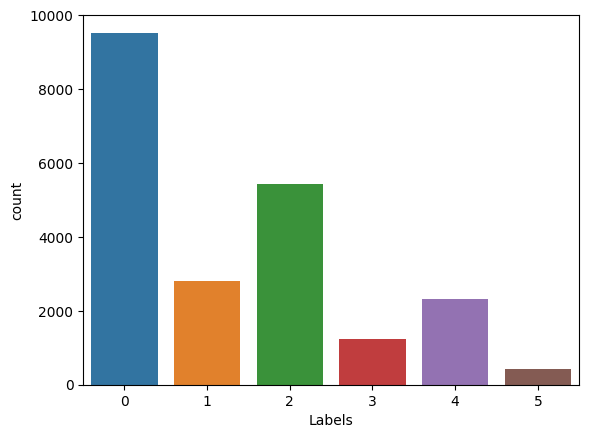

In [15]:
sns.countplot(data=final_data,x='Labels')

# ECG Signals...

In [28]:
class ECG_Data(Dataset):
    def __init__(self,dataframe):
        self.data=dataframe
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self,idx):
        path='C:\\Users\\ppjotrek\\Uni\\mgr\\1Sem\\KBCIDM\\Projekt\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1\\'+self.data['filename_lr'][idx]
        file_audio=wfdb.rdsamp(path)
        data=file_audio
        data_new=np.array(data[0])
        data_new=np.transpose(data_new,(1,0))
        data_final=data_new[7]
        label=self.data['Labels'][idx]
        data_final=torch.Tensor(data_final)
        return data_final,label

# MODEL Architecture

In [29]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1=nn.Linear(in_features=1000,out_features=4000,bias=True)
        self.dropout1=nn.Dropout(p=0.5,inplace=False)
        self.relu=nn.ReLU()
        self.fc2=nn.Linear(in_features=4000,out_features=8000,bias=True)
        self.dropout2=nn.Dropout(p=0.5,inplace=False)
        self.fc3=nn.Linear(in_features=8000,out_features=6)
    def forward(self,x):
        out1=self.fc1(x)
        out1=self.dropout1(out1)
        out1=self.relu(out1)
        out2=self.fc2(out1)
        out2=self.dropout2(out2)
        out2=self.relu(out2)
        out=self.fc3(out2)
        return out
   

In [30]:
model=Net()
#Optimizer
optim=torch.optim.Adam(params=model.parameters(),lr=0.001)
#Loss function
loss=torch.nn.CrossEntropyLoss()

In [31]:
from sklearn.model_selection import train_test_split
ECG_train,ECG_test=train_test_split(final_data,test_size=0.2,random_state=42)
ECG_train=ECG_train.reset_index()
ECG_test=ECG_test.reset_index()
train_dataset=ECG_Data(ECG_train)
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=64)
test_dataset=ECG_Data(ECG_test)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=64)

In [32]:
from sklearn.metrics import accuracy_score
def acc(op,labels):
    op=torch.softmax(op,dim=1)
    op=torch.detach(op).numpy()
    op=np.argmax(op,axis=1)
    acc=accuracy_score(op,labels)
    return acc
num_min_batches=0
for index in range(10):
        for idx,data in enumerate(train_loader):
            signal,label=data
            optim.zero_grad()
            output=model(signal)
            loss_=loss(output,label)
            loss_.backward()
            optim.step()
            num_min_batches+=1
            acc_score=acc(output,label)
            print('Epoch : {}/{} Mini Batch: {} Accuracy : {}'.format(index+1,10,num_min_batches+1,acc_score),end="\r")
            